In [46]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import string
from nltk.corpus import stopwords
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Question #1

In [47]:
path_to_file = r"gender-classifier-DFE-791531.csv"

loaded_tweets = pd.read_csv(path_to_file, encoding='latin-1')

genders = {'female', 'male', 'brand'}
clean_loaded_tweets = loaded_tweets.loc[loaded_tweets['gender'].isin(genders)]

clean_loaded_tweets.loc[loaded_tweets['text'].isnull(), 'text'] = "-"
clean_loaded_tweets.loc[loaded_tweets['description'].isnull(), 'description'] = "-"

tweets = clean_loaded_tweets["text"].map(str) + " " + clean_loaded_tweets["description"]

#### Loaded Tweets by Gender

In [48]:
print(loaded_tweets["gender"].value_counts())

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64


#### Cleaned Tweets by Gender

In [49]:
print(clean_loaded_tweets["gender"].value_counts())

female    6700
male      6194
brand     5942
Name: gender, dtype: int64


## Text Pre-Processing

In [50]:
punctuation = list(string.punctuation)
stop_words = set(stopwords.words('english') + punctuation + list("__"))

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]

tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)


def clean_and_tokenize(text):
    tokenized_clean_text = []
    text = re.sub(r'[^\x00-\x7f]*', r'', text)
    tokens = tokens_re.findall(text)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    for token in tokens:
        if token in stop_words:
            continue
        tokenized_clean_text.append(token)
    return tokenized_clean_text

#### Tokenizing cleaned tweets

In [51]:
tokenized_tweets = []

for tweet in tweets:
    if isinstance(tweet, str):
        tokenized_tweet = clean_and_tokenize(tweet)
        tokenized_tweets.append(tokenized_tweet)
        
gender_column = clean_loaded_tweets["gender"]
counter = Counter(gender_column)
genders = counter.keys()
tweet_amount = counter.values()

### Class Distribution

Tweet Distributions By Gender


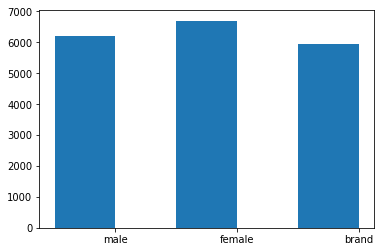

In [52]:
indexes = np.arange(len(genders))
plt.bar(indexes, tweet_amount, 0.5)
plt.xticks(indexes + 0.5 * 0.5, genders)
print('Tweet Distribution By Gender')
plt.show()

In [53]:
def get_gender_most_common_terms(terms,top):
    res = []
    counter = Counter()
    for term in terms:
        res.extend([token for token in clean_and_tokenize(term)])
    counter.update(res)
    return counter.most_common(top)

#### Get most common terms by gender

In [54]:
top_amount = 50

for gender in genders:
    gender_most_common_terms=get_gender_most_common_terms(loaded_tweets.loc[loaded_tweets['gender'] == gender]['text'],top_amount)
    gender_most_common_terms=pd.DataFrame(gender_most_common_terms, columns=['Term', 'Count'])
    print(str.upper(gender[0])+ gender[1:]+ ' Most Common Terms\n')
    print(gender_most_common_terms)
    print('-'*30)


Male Most Common Terms

      Term  Count
0     like    352
1      get    346
2      one    267
3     time    232
4      new    216
5     love    209
6       go    205
7   people    197
8     good    186
9      day    186
10    know    184
11     see    168
12     got    159
13       2    159
14    back    157
15   think    157
16   would    154
17    best    152
18     amp    152
19    make    149
20   still    144
21    last    144
22      __    137
23    need    136
24    want    135
25       1    120
26     way    118
27  really    117
28   great    116
29     lol    113
30    game    113
31    year    110
32    well    109
33     via    108
34   going    108
35       u    107
36   world    103
37      im    102
38    much    102
39   first    101
----------------------------------------------------------------------------------------------------
Female Most Common Terms

      Term  Count
0     like    451
1      get    353
2       __    333
3      one    332
4     love    315
5  

# Question #2

In [55]:
import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import json
import keras.preprocessing.text as kpt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [56]:
text_list=[''.join([token + " " for token in tweet]) 
           for tweet in tokenized_tweets]

test_ratio=0.2

X_train, X_test, y_train, y_test = train_test_split(text_list, 
                                                    gender_column, 
                                                    test_size=test_ratio, 
                                                    shuffle=False)

tf_idf_vectorizer = TfidfVectorizer()
X_train_vectorized = tf_idf_vectorizer.fit_transform(X_train)
X_test_vectorized = tf_idf_vectorizer.transform(X_test)

term_cap = 5000
tokenizer = Tokenizer(num_words=term_cap)
tokenizer.fit_on_texts(text_list)
term_dictionary= tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(term_dictionary, dictionary_file)

In [1]:
def words_to_indices(txt):
    return [term_dictionary[word] 
            for word in kpt.text_to_word_sequence(txt)]

In [58]:
words_to_indices_train = [words_to_indices(text) for text in X_train]
words_to_indices_test=[words_to_indices(text) for text in X_test]

words_to_indices_train = np.asarray(words_to_indices_train)
words_to_indices_test = np.asarray(words_to_indices_test)

X_train_tokenized_matrix = tokenizer.sequences_to_matrix(words_to_indices_train, mode='binary')
X_test_tokenized_matrix = tokenizer.sequences_to_matrix(words_to_indices_test, mode='binary')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

### Keras

In [59]:
y_train_categorical_matrix = keras.utils.to_categorical(y_train_encoded, 3)
y_test_categorical_matrix = keras.utils.to_categorical(y_test_encoded, 3)

#### To prevent overfitting, we're using Dropout on hidden layers
For more information, please refer to this article:
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [60]:
model = Sequential()
model.add(Dense(int(term_cap/2), input_shape=(term_cap,), activation='linear', name='layer_1'))
model.add(Dropout(0.5, name='layer_2'))
model.add(Dense(int(term_cap/4), activation='sigmoid', name='layer_3'))
model.add(Dropout(0.5, name='layer_4'))
model.add(Dense(len(genders), activation='softmax', name='layer_5'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
layer_2 (Dropout)            (None, 2500)              0         
_________________________________________________________________
layer_3 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
layer_4 (Dropout)            (None, 1250)              0         
_________________________________________________________________
layer_5 (Dense)              (None, 3)                 3753      
Total params: 15,632,503
Trainable params: 15,632,503
Non-trainable params: 0
_________________________________________________________________


#### Training Keras

In [ ]:
print("Training Keras")
print('-'*20)

batch = 32
num_iterations = 3
visible = 1

model.fit(X_train_tokenized_matrix, y_train_categorical_matrix,
  batch_size = batch,
  epochs = num_iterations,
  verbose = visible,
  validation_data = (X_test_tokenized_matrix, y_test_categorical_matrix), shuffle = True)

Training Keras
--------------------
Train on 15068 samples, validate on 3768 samples
Epoch 1/3
 3200/15068 [=====>........................] - ETA: 2:54 - loss: 1.0716 - acc: 0.5100

#### Testing Keras

In [ ]:
print("Testing Keras")
scores = model.evaluate(X_test_tokenized_matrix, y_test_categorical_matrix, verbose = 1)

In [ ]:
print("Params: batch_size = "+str(batch)+"\tepochs = "+str(num_iterations))
print("Model Accuracy %.2f" % (scores[1]*100))

In [ ]:
#with open('model.json', 'w') as json_file:
#    json_file.write(model.to_json())
#weights_file_name = 'modelWeights'
#model.save_weights(weights_file_name+'.h5')

#### Classifiers: SVN and K-Nearest Neighbors

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn import metrics

#### Classifier train and test function

In [ ]:
def test_classifier(classifier,classifier_name, X_train, X_test):
    #Train
    print("Training "+classifier_name)
    print('-'*20)
    classifier.fit(X_train, y_train)

    #Test 
    print("Testing "+classifier_name)
    pred = classifier.predict(X_test)

    #Accuracy Evaluation
    accuracy = metrics.accuracy_score(y_test, pred)

    print("Accuracy: %.2f" % accuracy)
    print()

In [ ]:
results_tfidf = []
classifiers = [(SGDClassifier(), "SVM"),(KNeighborsClassifier(), "K-Nearest Neighbors")]

for classifier, classifier_name in classifiers:
    test_classifier(classifier,classifier_name, X_train_vectorized, X_test_vectorized)

# Question #3

#### Find most common country - US & Canada

In [ ]:
tweet_location_train, tweet_location_test = train_test_split(clean_loaded_tweets["user_timezone"], 
                                                           test_size=0.30, 
                                                           shuffle = False)
tweet_location_train = tweet_location_train.dropna()

counter = Counter()
counter.update(tweet_location_train)
print(counter.most_common(1))

### Twitter Mining

In [ ]:
import tweepy
from tweepy import OAuthHandler

## OAuth

In [ ]:
def authenticate(consumer_key,
                 consumer_secret, 
                 access_token, 
                 access_secret):
    
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return tweepy.API(auth, wait_on_rate_limit = True)

In [ ]:
api = authenticate('xGmH3k9cREZ4hpnjsYQtIQ5um',
                  '25bBLLue9d9LT8RySWTTG4dwvn0iEbymwpvgfvUtsopghkLVrL',
                  '2827486724-433UvU84r38VPaAbmqyzT95MvjHUIcB25NUZYQ7',
                  'GuGv8nwmVEv8u3ItlpYNwxoO5HOzAseic6RlgETXffd71')


In [ ]:
tweets_file_name = 'tweetsFromAPI'

### Define Custom StreamListener

#### Saves the tweeets to file by batch downloading

In [ ]:
class TweetStreamListener(tweepy.StreamListener):
    
    def __init__(self, api=None):
        super(TweetStreamListener, self).__init__()
        self.num_tweets = 0

    def on_data(self, data):
        if self.num_tweets < 15000:
                try:
                    with open(tweets_file_name+'.json', 'a') as tweet_file:
                        tweet_file.write(data)
                        self.num_tweets += 1
                        return True
                except BaseException as e:
                    print("Error on_data: " + str(e))
                    return True
        else:
            return False

    def on_error(self, status):
        print("Error: "+status)
        return True

In [ ]:
#tweet_listener = TweetStreamListener()
#tweet_stream = tweepy.Stream(auth=api.auth, listener=tweet_listener)
#tweet_stream.filter(locations=[-162.8,28.2,-64.4,71.6])

#### Read and pre-process tweets from file

In [ ]:
#tweet_file = open(tweets_file_name+'.json', "r")
with open(tweets_file_name + '.json') as tweet_file:
    proccessed_tweets = []
    for jsonStr in tweet_file:
        try:
            tweet = json.loads(jsonStr)
        except:
            continue
            
        tweet_text = tweet['text']
        #print("Text: "+tweet_text)
        tweet_id = tweet['id']
        #print("ID: "+str(tweet_id))
            
        cleaned_tweet_text = ""
        for token in clean_and_tokenize(tweet_text):
            cleaned_tweet_text += token + " "
            
        #print(cleaned_tweet_text)
        #print('-'*10)['Tweet_ID','Tweet_Text']
        proccessed_tweets.append({'Tweet_ID': tweet_id, 'Tweet_Text': cleaned_tweet_text})

In [ ]:
proccessed_tweets = pd.DataFrame(proccessed_tweets)

In [ ]:
#print(proccessed_tweets)

#### Pre-Proccess the tweets

In [ ]:
#for loaded_tweet in loaded_tweets:
#    text = ""
#    for token in clean_and_tokenize(loaded_tweet):
#        text += token + " "
#    proccessed_tweets.append(text)

#print(proccessed_tweets)

#### Get term count from downloaded tweets

In [ ]:
data = get_gender_most_common_terms(proccessed_tweets['Tweet_Text'], top_amount)
term_df = pd.DataFrame(data, columns = ['Term','Frequency'])

print(term_df)

#### Tokenize the terms

In [ ]:
tokenizer = Tokenizer(num_words=term_cap)

## Question #4

In [ ]:
def textToArr(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in term_dictionary:
            wordIndices.append(term_dictionary[word])
    return wordIndices

#### Predict the gender of the downloaded tweets

In [ ]:
genders = ['brand', 'female', 'male']
prediction_df = []#pd.DataFrame(columns=['Tweet ID','Predicted Gender'])

for id in proccessed_tweets['Tweet_ID']:
    tweet_text = proccessed_tweets.loc[proccessed_tweets['Tweet_ID'] == id]['Tweet_Text']
    tweet_text = tweet_text.to_string()
    #print(type(tweet_text))
    testArr = textToArr(tweet_text)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    pred = model.predict(input)
    data = tweet_text + "," + str(genders[np.argmax(pred)]) + "," + str(pred[0][np.argmax(pred)] * 100) + '\n'
    pred_gender= str(genders[np.argmax(pred)])
    #row = 
    #print(row)
    prediction_df.append([id,pred_gender])#[id]= pred_gender

In [ ]:
#print(prediction_df)
#print('-'*20)
prediction_df=pd.DataFrame(prediction_df, columns = ['id', 'gender'])
#print(prediction_df)

In [ ]:
prediction_df['gender'].value_counts()

In [ ]:
from genderize import Genderize

tweet_file = open(tweets_file_name+'.json', "r")
downloaded_tweets_id_name = dict()
#a=0
for jsonStr in tweet_file:
    try:
        tweet = json.loads(jsonStr)
        downloaded_tweets_id_name[tweet['id']]=tweet['user']['name']
        #a=a+1
        #if a> 1000:
            #break
    except:
        continue

In [ ]:
names = set([downloaded_tweets_id_name[id].split()[0] for id in downloaded_tweets_id_name])
#print(downloaded_tweets_id_name)

#### To determine the accuracy of our model on the downloaded tweets, we compare our predicted gender to a prediction of another source - the Genderize API - more on the API at https://genderize.io/
This API is throwing an exception if the request rate is too high, so to avoid technical problems we downloaded the most accurate predicitons (above 80%) to a csv.
The purpose of using this data is to compare our data to our models predictions and help us determine its accuracy for predicting the gender for live tweets.

In [ ]:
#names set, in order to use only distinct values
genderizer = Genderize(timeout = 5.0)

path_to_genderized_file = 'name_gender.csv'
try:
    names_gender = genderizer.get(names)
    names_gender.to_csv(path_to_genderized_file)
except Exception as e: 
    print(e)
    names_gender = pd.read_csv(path_to_genderized_file, encoding='latin-1')

In [ ]:
#print(names_gender)

#### Calculate the accuracy of our model

In [ ]:
true_positive = 0
total = 0
for tweet_id in downloaded_tweets_id_name:
    tweet_name = downloaded_tweets_id_name[tweet_id].split()[0]
    genderized_gender = names_gender.loc[names_gender['name'] == tweet_name]['gender']
    if not genderized_gender.empty:
        total += 1
        genderized_gender = genderized_gender.max()
        predicted_gender = prediction_df.loc[prediction_df['id'] == tweet_id]['gender'].max()

        if genderized_gender == predicted_gender:
            true_positive += 1

In [ ]:
accuracy = true_positive/total
print("Accuracy: %.2f" % accuracy)